In [483]:
from all_data_paths_py import img_datas
from torch.utils.data import Dataset
import torchio as tio
import torch
import numpy as np
import os
import torch


img_datas = [
'/cpfs01/shared/gmai/medical_preprocessed/3d/semantic_seg/mr_unknown/ACDC',
'/cpfs01/shared/gmai/medical_preprocessed/3d/semantic_seg/mr_unknown/EMIDEC',
'/cpfs01/shared/gmai/medical_preprocessed/3d/semantic_seg/mr_unknown/COSMOS2022',
]

with open('random_choice.py', 'w') as f:
    f.writelines('random_choice = [\n')

    for i in img_datas:
        if os.path.exists(os.path.join(i, 'imagesTr')):
            for j in os.listdir(os.path.join(i, 'imagesTr')):
                # print(os.path.join(i, 'imagesTr', j))
                f.writelines('\''+os.path.join(i, 'imagesTr', j)+'\',\n')
                break
    f.writelines(']\n')


In [496]:
im_pa = '/cpfs01/shared/gmai/medical_preprocessed/3d/semantic_seg/mr_unknown/COSMOS2022/imagesTr/case_0005.nii.gz'


print(im_pa.split('/')[-4] + '----' + im_pa.split('/')[-3])
la_pa = im_pa.replace('imagesTr', 'labelsTr')


mr_unknown----COSMOS2022


tensor([0, 1], dtype=torch.uint8)
tensor(18192)


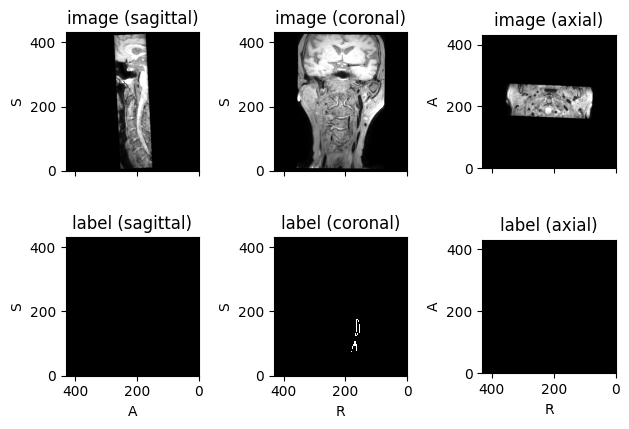

In [498]:
subject = tio.Subject(
    image = tio.ScalarImage(im_pa),
    label = tio.LabelMap(la_pa),
)
subject.label.set_data(subject.label.data.type(torch.uint8))
print(torch.unique(subject.label.data))
print(subject.label.data.sum())
subject.plot()

selected_value: tensor([[1]], dtype=torch.uint8)


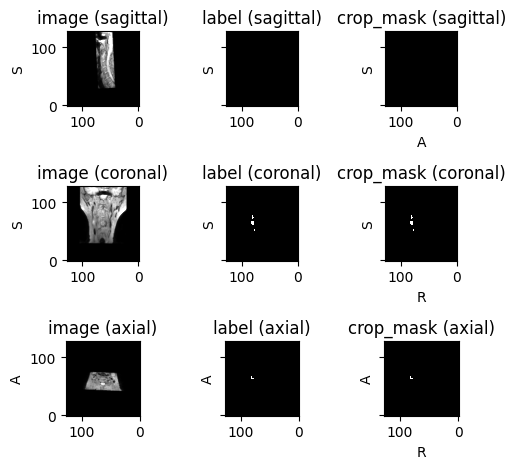

In [499]:
transform=tio.Compose([
    tio.ToCanonical(),
    tio.Resample(1),
    tio.Resize((128,128,128)),
    tio.CropOrPad(mask_name='crop_mask', target_shape=(128,128,128)), # crop only object region
    tio.KeepLargestComponent(label_keys='crop_mask'),
    # tio.RandomAffine(degrees=[-np.pi/8, np.pi/8], scales=[0.8, 1.25]),
    # tio.RandomFlip(axes=(0, 1, 2)),
    # tio.RemapLabels({2:1, 3:1}),
])

subject = tio.Subject(
    image = tio.ScalarImage(im_pa),
    label = tio.LabelMap(la_pa),
)
# TODO: 加上这行确保是uint8格式的数据
subject.label.set_data(subject.label.data.type(torch.uint8))
# TODO: 判断label是否是全0
if subject.label.data.sum() == 0:
    print('label is all zero')
    # 过滤掉为0的数据
    # 过滤掉太小值的数据
    # continue
############################ get two class ############################
return_label = subject.label.data.clone().detach()
# 给定的 tensor
labels_num = torch.unique(return_label)
# 获取大于0的索引
nonzero_indices = torch.nonzero(labels_num > 0)
# 从索引中随机选择一个
random_index = torch.randint(0, nonzero_indices.size(0), (1,))
selected_value = labels_num[nonzero_indices[random_index]]
print(f'selected_value: {selected_value}')
# 输出结果
return_label_num = selected_value.item()
return_label[return_label != return_label_num] = 0
return_label[return_label == return_label_num] = 1

############################ get two class ############################
subject.add_image(tio.LabelMap(tensor=return_label,
                                affine=subject.label.affine),
                    image_name="crop_mask")

# print(subject.image.data.shape)
# print(subject.label.data.shape)
# print(subject.crop_mask.data.shape)

subject = transform(subject)
# TODO: 加上这几句处理不合格数据
if subject.crop_mask.data.sum() < 100:
    print('crop_mask is too small')
    # 过滤掉为0的数据
    # 过滤掉太小值的数据
subject.plot()

In [388]:
# torch.unique(subject.crop_mask.data)
subject.crop_mask.data.sum()

tensor(126333)

In [407]:
subject.image.data.shape

torch.Size([1, 128, 128, 128])

In [42]:
subject.label.data.sum()

tensor(0)

In [46]:
torch.argwhere(return_label)

tensor([[  0, 275, 394, 236],
        [  0, 289, 336,  87],
        [  0, 290, 428, 211],
        [  0, 291, 424, 104],
        [  0, 334, 424, 212]])